# Cookie Cats Mobile Game A/B Testing

## About the dataset

### Scenario
This dataset contains data collected for the purpose of examining what happens when the first gate in the game is moved from level 30 to level 40. To conduct the experiment, when a player installed the game, they are randomely assigned to either gate_30 or gate_40 category.

### Goal
The goal is to examine the dataset by conducting an A/B test to determine if it's better to have the gate show up at level 30 or rather 40. In other words: "Does the gate placement at level 40 lead to higher 7-day retention rates compared to level 30? Does the sum of gamerounds change as well? If so, how?"

### Columns
- userid: A unique number that identifies each player.
- version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
- retention_1: Did the player come back and play 1 day after installing?
- retention_7: Did the player come back and play 7 days after installing?

### Analysis Overview
- **Data pre-processing**
- **Exploratory data analysis and visualizations**
- **Checking test assumptions**
- **A/B test**
- **Conclusion and Summary**

### Methodology and Metrics
In this analysis we have two versions of a game and we aim to find if there is any statistically significant differences between these versions. By having a quick look at the column descriptions it is clear that we have 2 different metrics which we need to consider:
- First, the `sum_gamegrounds` column. Through this metric we answer the question: "Does the sum of gamerounds change between the two versions?" For this we would need to perform an A/B test appropriate for a continous metric.
- Second, the `retention_7` column, where we answer the question: "Does the gate placement at level 40 lead to higher 7-day retention rates compared to level 30?". For this test, we have two different samples and two different proportions for each game version, and would need to perform an A/B test that compares two proportions for a discrete metric.

*The significance level for all of the hypothesis tests will be 5% (0.05).*

## Data pre-processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import warnings
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "svg"

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("datasets/cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


We can see that the dataset is quite large, there are no missing values in any of the columns, and the datatypes all align with the analysis to be performed.

In [4]:
df.duplicated().sum()

np.int64(0)

In [5]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userid,90189.0,NaN,NaN,NaN,4998412.234496,2883285.6077,116.0,2512230.0,4995815.0,7496452.0,9999861.0
version,90189,2,gate_40,45489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum_gamerounds,90189.0,NaN,NaN,NaN,51.872457,195.050858,0.0,5.0,16.0,51.0,49854.0
retention_1,90189,2,False,50036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retention_7,90189,2,False,73408,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at the `sum_gamerounds` column, the max values seems very high, which to me indicates the presence of outliers. Let's check for and remove outliers if needed:

In [6]:
def find_outliers_iqr(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies outliers in a DataFrame using the Interquartile Range (IQR) method.
    Parameters:
    df (pd.DataFrame): The input DataFrame containing numeric columns to check for outliers.
    Returns:
    pd.DataFrame: A DataFrame of the same shape as the input, with boolean values indicating
                  whether each value is an outlier (True) or not (False) for each numeric column.
    """

    numeric_columns = df.select_dtypes(include=[np.number]).columns
    outliers_df = pd.DataFrame(index=df.index)
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_df[f"{column}"] = (df[column] < lower_bound) | (
            df[column] > upper_bound
        )

    return outliers_df

In [7]:
outliers = find_outliers_iqr(df)
outliers.sum()

userid                0
sum_gamerounds    10177
dtype: int64

More than 10 thousand outliers are in the dataset, given the huge number of users, I would say that removing that data would significantly affect the analysis. Therefore, I will only be excluding the outliers from the visualization of the distributions and not from the rest of the analysis. This way, I avoid creating an extremely zoomed out plot that includes extreme outliers with values such as 49854 in the sum_gameround column.

In [8]:
df_vis = df.copy()
df_vis.sum_gamerounds = df.sum_gamerounds[outliers.sum_gamerounds == False]
df_vis.dropna(inplace=True)

For now let's focus on our first dependent variable, the `sum_gamerounds` column:

In [9]:
df.describe()[["sum_gamerounds"]].T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,5.0,16.0,51.0,49854.0


In [10]:
df.groupby("version")["sum_gamerounds"].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


From the two tables above, it is easy to suspect that the distribution of sum_gamerounds is not normal, and is in fact skwed to the right, because the median is much smaller than the mean. Additionally, we can see that the data is quite evenly distributed between the two versions, but we can run a chisquared test to confirm.

Let's find out if the number of game rounds is different for people who stuck to the game after 1 and 7 days:

In [11]:
df.groupby(["version", "retention_1"]).sum_gamerounds.agg(["describe"])

describe                                                 \
                       count       mean         std  min   25%   50%    75%   
version retention_1                                                           
gate_30 False        24666.0  18.379591  319.423232  0.0   2.0   6.0   16.0   
        True         20034.0  94.411700  135.037697  0.0  22.0  48.0  111.0   
gate_40 False        25370.0  16.340402   35.925756  0.0   2.0   6.0   16.0   
        True         20119.0  95.381182  137.887256  0.0  21.0  49.0  112.0   

                              
                         max  
version retention_1           
gate_30 False        49854.0  
        True          2961.0  
gate_40 False         1241.0  
        True          2640.0

In [12]:
df.groupby(["version", "retention_7"]).sum_gamerounds.agg(["describe"])

describe                                                   \
                       count        mean         std  min   25%    50%    75%   
version retention_7                                                             
gate_30 False        36198.0   25.796508   43.316158  0.0   4.0   11.0   31.0   
        True          8502.0  165.962479  568.000576  0.0  48.0  105.0  208.0   
gate_40 False        37210.0   25.856356   44.406112  0.0   4.0   11.0   30.0   
        True          8279.0  165.649837  183.792499  0.0  52.0  111.0  211.0   

                              
                         max  
version retention_7           
gate_30 False          981.0  
        True         49854.0  
gate_40 False         2640.0  
        True          2294.0

From the two tables above we can see that there is no noticeable confounding effect between the two metrics where one would cause the other to change drastically.

In [13]:
df.groupby("version").retention_7.agg(["count", "mean", "std"])

,count,mean,std
version,,,
gate_30,44700,0.190201,0.392464
gate_40,45489,0.182000,0.385849


In [14]:
pd.crosstab(df.version, df.retention_7, normalize="index")

retention_7,False,True
version,,
gate_30,0.809799,0.190201
gate_40,0.818000,0.182000


From the two tables above we can see that 19% of the players came back to play after 7 days for the gate_30 version, and only 18% came back for the gate_40 version. At first glance, I would say that the 1% difference is considerable when taking into account the number of players, but we need to verify if this difference is statistically significant.

## EDA and Visualizations

Let's explore the distribution of both our metrics starting with the sum_gamerounds first:

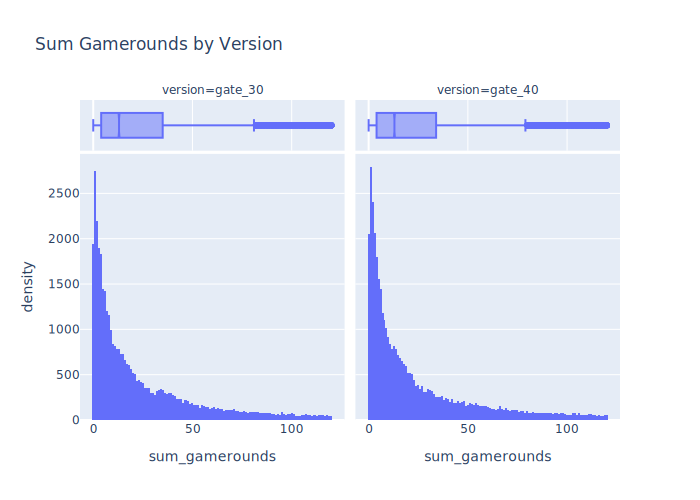

In [15]:
px.histogram(
    df_vis,
    x="sum_gamerounds",
    facet_col="version",
    marginal="box",
    histnorm="density",
    title="Sum Gamerounds by Version",
)

Text(0.5, 1.0, 'Boxplot of sum_gamerounds by version')

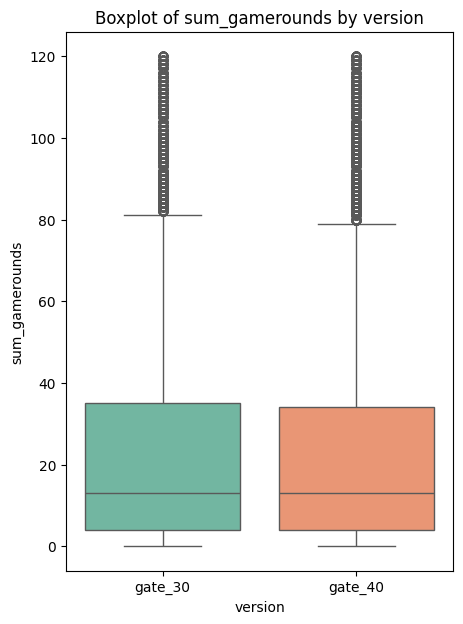

In [16]:
plt.figure(figsize=(5, 7))
sns.boxplot(data=df_vis, y="sum_gamerounds", x="version", palette="Set2")
plt.title("Boxplot of sum_gamerounds by version")

The densities and the medians of the gamerounds are very similar for both versions. Now it would be a good idea to run a chisquared test to detect sample ratio mismatch:

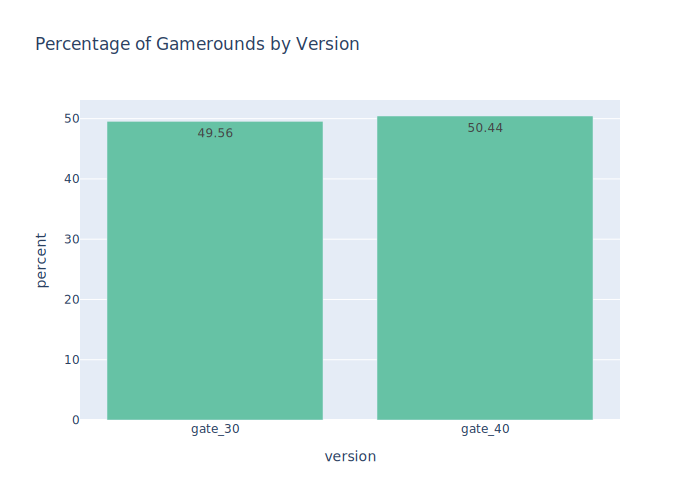

In [17]:
gameround_percent = (
    (df.groupby("version").sum_gamerounds.count() / df.sum_gamerounds.count()) * 100
).reset_index()
gameround_percent.columns = ["version", "percent"]
gameround_percent.percent = gameround_percent.percent.round(2)

px.bar(
    gameround_percent,
    x="version",
    y="percent",
    title="Percentage of Gamerounds by Version",
    text="percent",
    color_discrete_sequence=px.colors.qualitative.Set2,
)

In [18]:
stats.chisquare(df.version.value_counts()).pvalue

np.float64(0.008607987810836262)

After running the test, we can see that the pvalue is well below the 0.05 significance level, therefore, there is significant SRM dtetcted between version and sum_gamerounds columns. However, for the sake of simplicity, I will not be weighing the sample to correct the SRM.

Let's explore the retention_7 and retention_1 columns:

Text(0.5, 1.0, 'Retention 1 counts')

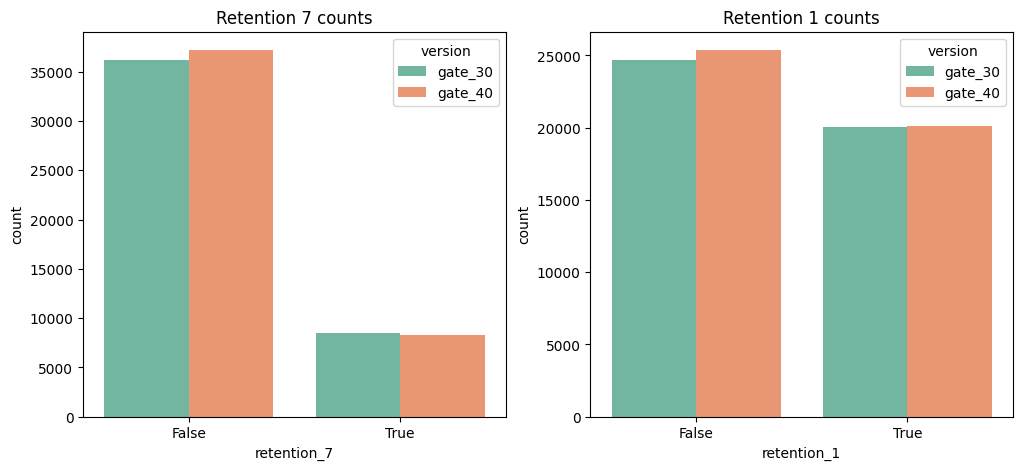

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.countplot(df, x="retention_7", hue="version", palette="Set2")
plt.title("Retention 7 counts")

plt.subplot(122)
sns.countplot(df, x="retention_1", hue="version", palette="Set2")
plt.title("Retention 1 counts")

There is a larger number of players who keep playing after day 1 as compared to day 7, but that is to be expected. Furthermore, there is no visible diffence between the players who kept playing either version after day 1, but there is a very slight difference in day 7.

## Checking test assumptions

I will be checking for three assumptions:

1. Does the data follow a normal distribution?
2. Is the variance homogeneous?
3. Are the observations independent of each other?

By answering these questions I will then be able to understand which kind of A/B test I need to run.

In [20]:
gameround_gate30 = df.loc[df.version == "gate_30", "sum_gamerounds"]
gameround_gate40 = df.loc[df.version == "gate_40", "sum_gamerounds"]

Although we plotted the distribution above and visually confirmed it is not normal, to test normality I will be running a Shapiro test, under the hypothesis:
- H_0: The distribution is normal.
- H-A: The distribution is not normal.

In [21]:
stats.shapiro(gameround_gate30).pvalue, stats.shapiro(gameround_gate40).pvalue

(np.float64(2.146395844442685e-157), np.float64(3.3446548187520663e-140))

The pvalues for both distributions are way below the significance level, thus the null hypothesis is rejected and the distributions are confirmed not to be normal.

To check for homogenity of variance, I will run a Levene test, where:
- H_0: There's no difference in variance between gate_30 and gate_40.
- H_A: There is a difference in variance.

In [22]:
stats.levene(gameround_gate30, gameround_gate40).pvalue

np.float64(0.46694516772623273)

From the result above, the null hypothesis could not be rejected, therefore, the variance is homogeneous.

In [23]:
df.userid.count() == df.userid.nunique()

np.True_

As we can see, the third assumption is also met, because each user/account is unique and does not account for more than one datapoint, thus the data are independent.

![image](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*Vzkwzrs4DOmBBa1LymW-PQ.png)

The decision tree above makes it easy to visualize the path that needs to be followed for the analysis and helps us make a decision on which A/B test to run.

In the case of sum_gamerounds, since we are dealing with a continuous metric, in which the sample size is not too large (80k), and the distribution of the data is not normal; we would need to use a `Mann-Whitney U test`.

In the case of retention_7, since we are dealing with a discrete metric (T/F), in which the sample size is considerably large enough (>5); a `Pearson's chi test` is more appropriate.

## A/B testing

**QUESTION: Does the sum of gamerounds change between the two versions of the game?**

First let's test sum_gamerounds.

The test hypothesis are as follows:

- H_0: There is no difference between the sum of gamerounds between the two versions. (Populations are equal)
- H_A: The sum of gamerounds is different between the two versions. (Populations are different)

Let's run the test and see:

In [24]:
mann_whitney = stats.mannwhitneyu(gameround_gate30, gameround_gate40)
mann_whitney.pvalue

np.float64(0.05020880772044255)

Given the pvalue, we fail to reject the null hypothesis and assume that there is no statistically significant difference between the sum of gamerounds of the two game versions.

Let's calculate the confidence interval both analytically and using the bootstrap method:

In [25]:
def analytical_ci(g1, g2):
    n1, n2 = len(g1), len(g2)
    mean1, mean2 = np.mean(g1), np.mean(g2)
    std1, std2 = np.std(g1, ddof=1), np.std(g2, ddof=1)

    se1 = std1 / np.sqrt(n1)
    se2 = std2 / np.sqrt(n2)
    mean_diff = mean1 - mean2
    se_diff = np.sqrt(se1**2 + se2**2)

    z_critical = stats.norm.ppf(0.975)
    ci_lower = mean_diff - z_critical * se_diff
    ci_upper = mean_diff + z_critical * se_diff

    return ci_lower, ci_upper


def bootstrap_ci(g1, g2, n_boot=10000, alpha=0.05):
    boot_diffs = []
    for _ in range(n_boot):
        boot1 = np.random.choice(g1, size=len(g1), replace=True)
        boot2 = np.random.choice(g2, size=len(g2), replace=True)
        boot_diffs.append(np.mean(boot1) - np.mean(boot2))

    return (
        np.percentile(boot_diffs, alpha / 2 * 100),
        np.percentile(boot_diffs, (1 - alpha / 2) * 100),
    )

In [26]:
CI = {
    "Analytical": analytical_ci(gameround_gate30, gameround_gate40),
    "Bootstrapping": bootstrap_ci(gameround_gate30, gameround_gate40),
}

In [27]:
pd.DataFrame(CI).T.rename(columns={0: "Lower Bound", 1: "Upper Bound"})

,Lower Bound,Upper Bound
Analytical,-1.404675,3.719652
Bootstrapping,-1.007338,4.027739


The CIs produced back up the claim of the Mann-Whitney test: Since 0 is included in the confidence interval for both methods, we cannot reject the notion that there is no difference between the sum of gamerounds between the two versions of the game.

**QUESTION: Does the gate placement at level 40 lead to higher 7-day retention rates compared to level 30?**

Let's consider our second metric, the retention_7 column. Here we will conduct the chi2 test.

For this test, the hypothesis are as follows:

- H_0: There is no difference between the proportions of people who return to play after day 7 between the two game versions.
- H_A: One version of the game has a higher proportion of people who return to play after day 7.

In [28]:
sm.stats.proportions_chisquare(
    [
        df.retention_7[df.version == "gate_30"].sum(),
        df.retention_7[df.version == "gate_40"].sum(),
    ],
    [
        df.retention_7[df.version == "gate_30"].count(),
        df.retention_7[df.version == "gate_40"].count(),
    ],
)[1]

np.float64(0.0015542499756142788)

Since the p-value is way lower than 0.05, we reject H_0 and assume that there is a statistically significant difference between the proportions of the people who returned to play the game on day 7.


Let's visualize the difference to see which version "captivates the players more":

Text(0, 0.5, 'Number of players')

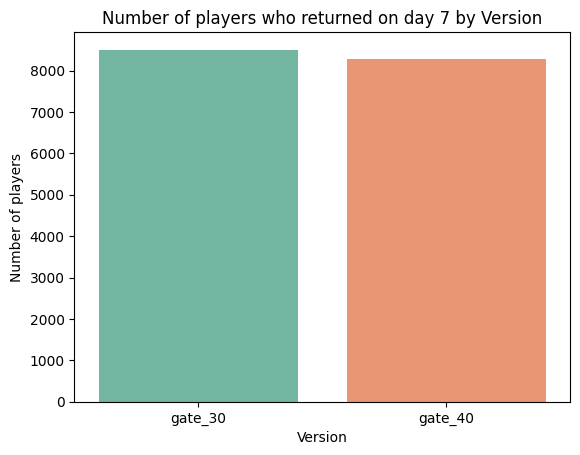

In [29]:
vis = df.groupby("version").retention_7.sum()
sns.barplot(x=vis.index, y=vis.values, palette="Set2")
plt.title("Number of players who returned on day 7 by Version")
plt.xlabel("Version")
plt.ylabel("Number of players")

As we can see from the barchart above, there is a higher number of players returning to play on day 7 for the gate_30 version of the game as opposed to the gate_40 version. 

From a player's perspective this finding makes sense. The player is less likely to lose interest on the game if the first gate appears sooner, so after 30 levels, as opposed to after 40 levels. So, in my opinion, the gate_30 version is more captivating.

# Conclusions and Summary

## Overview

In this analysis, I examined the impact of gate placement on two key metrics in the Cookie Cats mobile game: the total sum of gamerounds played and the 7-day retention rate. The experiment compared players assigned to either gate_30 or gate_40, aiming to assess which approach leads to better player engagement.

## Key Findings

- The dataset contains a large number of players with notable outliers in the sum_gamerounds metric, which were excluded from visualization to better understand the underlying distributions.
- The distribution of sum_gamerounds is right-skewed for both versions, with similar central tendencies despite a slight sample ratio mismatch.
- Normality tests rejected the normal distribution hypothesis while Levene's test confirmed homogeneous variances, leading to the use of the Mann-Whitney U test for the continuous metric.
- The Mann-Whitney U test did not find a statistically significant difference in the sum of gamerounds between gate_30 and gate_40.
- A chi-squared test on the binary 7-day retention metric revealed a statistically significant difference, with the gate_30 version achieving a higher retention rate compared to gate_40.

## Recommendation

Based on the analysis, although total gamerounds remain similar across both versions, the higher 7-day retention rate observed in the gate_30 group suggests that placing the gate earlier (at level 30) may enhance player engagement. Therefore, it is recommended to adopt the gate_30 placement strategy for improved long-term retention.

These findings imply that subtle design choices, such as the timing of in-game challenges, can have a meaningful impact on user behavior. While altering the gate placement does not change overall gameplay duration, it significantly influences early retention—a key indicator of long-term engagement and potential revenue. The enhanced retention in the gate_30 version indicates that a more accessible early-game challenge may help in better capturing and maintaining players' interest. Consequently, investing in strategies that optimize early user experience could lead to improved user lifetime value.
